<p><font size="6" color='grey'> <b>

Generative KI. Verstehen. Anwenden. Gestalten.
</b></font> </br></p>

<font size="5" color='grey'> <b>
SQL RAG mit Chat-Historie (Optimiert)
</b></font> </br>

**Optimierte Version von M13_SQL_RAG.ipynb**

---

<font color='black' size="5">
Optimierungen gegenüber M13
</font>

| # | Optimierung | Vorher (M13) | Nachher (M13a) |
|---|-------------|-------------|----------------|
| 1 | **Schema-Caching** | `db.get_table_info()` bei jedem Chain-Aufruf | Einmalig laden, Variable `db_schema` |
| 2 | **Structured Output** | `StrOutputParser()` + Regex-Bereinigung | `with_structured_output(SQLQuery)` |
| 3 | **Chain-Wiederverwendung** | `analysis_chain` bei jedem Aufruf neu erstellt | Einmalig definiert, wiederverwendet |
| 4 | **SQL-Validierung integriert** | `validate_sql()` existiert, aber nicht genutzt | In `execute_query()` integriert |
| 5 | **DB-Pfad** | Hardcoded `/content/northwind.db` | Relativer Pfad `northwind.db` |
| 6 | **Imports konsolidiert** | Doppelte Imports in Abschnitt 4 und 5 | Ein Import-Block |
| 7 | **Mermaid parametrisiert** | 4x fast identisches Diagramm | Funktion `show_architecture(highlight)` |
| 8 | **Historie ausgelagert** | Formatierung in `chatbot_response()` | Eigene Funktion `format_history()` |

In [4]:
#@title 🔧 Umgebung einrichten{ display-mode: "form" }
!uv pip install --system -q git+https://github.com/ralf-42/GenAI.git#subdirectory=04_modul
from genai_lib.utilities import (
    check_environment,
    get_ipinfo,
    setup_api_keys,
    mprint,
    install_packages,
    mermaid,
    get_model_profile,
    extract_thinking,
    load_chat_prompt_template
)
setup_api_keys(['OPENAI_API_KEY', 'HF_TOKEN'], create_globals=False)
print()
check_environment()
print()
get_ipinfo()

✓ OPENAI_API_KEY erfolgreich gesetzt
✓ HF_TOKEN erfolgreich gesetzt

Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

Installierte LangChain- und LangGraph-Bibliotheken:
langchain                                1.2.8
langchain-chroma                         1.1.0
langchain-classic                        1.0.1
langchain-community                      0.4.1
langchain-core                           1.2.9
langchain-ollama                         1.0.1
langchain-openai                         1.1.8
langchain-text-splitters                 1.1.0
langgraph                                1.0.7
langgraph-checkpoint                     4.0.0
langgraph-prebuilt                       1.0.7
langgraph-sdk                            0.3.3

IP-Adresse: 34.50.169.91
Hostname: 91.169.50.34.bc.googleusercontent.com
Stadt: Las Vegas
Region: Nevada
Land: US
Koordinaten: 36.1750,-115.1372
Provider: AS396982 Google LLC
Postleitzahl: 89111
Zeitzone: America/Los_Angeles


In [2]:
#@title 📂 Datenbank { display-mode: "form" }
# Northwind-Datenbank herunterladen
!rm -rf northwind.db
!curl -L https://raw.githubusercontent.com/ralf-42/GenAI/main/02_daten/05_sonstiges/northwind.db -o northwind.db

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.5M  100 23.5M    0     0  16.5M      0  0:00:01  0:00:01 --:--:-- 16.5M


<p><font color='black' size="5">
⏸️ 5-Minuten-Check:
</font></p>

**Ziel:** Prüfen, ob du das vorherige Kapitel verstanden hast – nicht, ob es gerade läuft.

**Aufgabe** (5 Minuten, ohne Vorlage):

Rekonstruiere die zentrale Idee oder Code-Struktur des letzten Abschnitts selbstständig
(kein Copy & Paste, kein Nachschlagen).

Wähle eine der folgenden Optionen:

+ Erkläre in 1–2 Sätzen, was hier konzeptionell passiert.

+ Verändere eine Kleinigkeit (z. B. Prompt, Parameter, Reihenfolge) und beschreibe die Auswirkung.

+ Markiere eine Stelle, die du nicht sicher erklären kannst, und formuliere eine konkrete Frage dazu.

**Hinweis:**
Nicht alles muss „fertig“ oder „korrekt“ sein. Entscheidend ist, wo dein Verständnis gerade endet

# 1 | Einführung in SQL RAG
---

SQL RAG ist eine Technologie, die Large Language Models (LLMs) mit Datenbankabfragen kombiniert. Sie ermöglicht es, natürlichsprachliche Anfragen in SQL-Abfragen zu übersetzen und die Ergebnisse intelligent zu interpretieren.

Diese Technologie überbrückt die Lücke zwischen menschlicher Sprache und Datenbankstrukturen, indem sie:

- Natürliche Sprache in präzise SQL-Abfragen umwandelt
- Datenbankschemas analysiert, um korrekte Abfragen zu generieren
- Die Abfrageergebnisse in verständliche Antworten umformuliert

SQL RAG erweitert die Fähigkeiten von LLMs, indem es ihnen Zugriff auf strukturierte Daten ermöglicht und so präzisere, faktenbasierte Antworten liefert.

<p><font color='black' size="5">
Warum SQL für RAG?
</font></p>



Das Erstellen eines Retrieval-Augmented Generation (RAG)-Systems bringt mehrere Herausforderungen mit sich, aber SQL könnte helfen, diese zu bewältigen:

- **SQL kann helfen, komplexe Daten abzurufen**
    
    Das Abrufen relevanter Informationen aus riesigen und vielfältigen Datensätzen kann komplex sein, insbesondere beim Umgang mit unstrukturierten oder semistrukturierten Datenquellen wie Textdokumenten, Bildern oder Multimedia. Die Integration effizienter Retrieval-Mechanismen, die diese Komplexität bewältigen können, ist eine bedeutende Herausforderung. Die Abfragefunktionen von SQL ermöglichen den effizienten Abruf relevanter Informationen aus diesen Datenquellen. Durch das Generieren von SQL-Abfragen, die auf bestimmte Kriterien zugeschnitten sind, und die Nutzung erweiterter Suchfunktionen kann SQL den Datenabrufprozess optimieren und so die Komplexität des Zugriffs auf verschiedene Datensätze bewältigen.
    
- **SQL kann helfen, Qualitätsdaten abzurufen**
    
    Die Sicherstellung der Qualität und Relevanz der abgerufenen Daten ist entscheidend für die Generierung genauer und sinnvoller Antworten. Verrauschte oder veraltete Daten sowie irrelevante Informationen können die Leistung des RAG-Systems jedoch negativ beeinflussen. Die Entwicklung von Algorithmen zum effektiven Filtern und Ranking abgerufener Daten ist eine Herausforderung. SQL bietet Mechanismen zum Filtern und Ranking abgerufener Daten basierend auf verschiedenen Kriterien wie Zeitstempeln, Kategorien oder Relevanzwerten.
    
- **SQL bietet Skalierbarkeit und Flexibilität**
    
    Da Datensätze an Größe und Komplexität zunehmen, wird Skalierbarkeit zu einer großen Herausforderung für RAG-Systeme. Die Sicherstellung, dass das System mit zunehmenden Datenmengen umgehen kann und gleichzeitig Leistung und Reaktionsfähigkeit aufrechterhält, erfordert ein effizientes Architekturdesign und Optimierungsstrategien. SQL-Datenbanken sind darauf ausgelegt, riesige Mengen strukturierter Daten effizient zu verwalten. Die Integration von SQL in RAG-Systeme adressiert eine der wichtigsten Herausforderungen im Bereich der KI: die Skalierung des Retrieval-Mechanismus zur Handhabung umfangreicher Datensätze, ohne die Leistung zu beeinträchtigen. Darüber hinaus ermöglicht die Flexibilität von SQL bei der Formulierung von Abfragen RAG, komplexe Informationen abzurufen und dabei die Breite und Tiefe der während des Generierungsprozesses berücksichtigten Daten anzupassen.
    
- **SQL hilft beim Abrufen von Echtzeitdaten**
    
    Die Bereitstellung von Echtzeitantworten ist für viele Anwendungen von RAG-Systemen, wie z. B. Chatbots oder virtuelle Assistenten, von entscheidender Bedeutung. Das Erreichen niedriger Latenzzeiten bei gleichzeitiger Aufrechterhaltung der Qualität der generierten Inhalte stellt eine Herausforderung dar, insbesondere in Szenarien mit strengen Latenzanforderungen. Die Optimierungstechniken von SQL, wie z. B. Query-Caching und Indizierung, können die Query-Verarbeitungszeiten erheblich reduzieren und es RAG-Systemen ermöglichen, Echtzeitantworten bereitzustellen.
    


# 2 | Vergleich SQL RAG vs RAG
---

Während sowohl SQL RAG als auch RAG (Retrieval-Augmented Generation) die Fähigkeiten von LLMs erweitern, gibt es wichtige Unterschiede:



| Merkmal         | SQL RAG      | Retrieval-Augmented Generation (RAG)    |
| --------------- | ------------------------------------ | --------------------------------------- |
| Datenquelle     | Strukturierte Datenbanken            | Textdokumente, Wissensbasen             |
| Abfragemethode  | SQL-Generierung                      | Semantische Suche, Embedding-Vergleiche |
| Datenstruktur   | Schema-basiert, tabellarisch         | Unstrukturiert oder semi-strukturiert   |
| Genauigkeit     | Präzise durch Datenbankintegrität    | Abhängig von der Retrieval-Qualität     |
| Anwendungsfälle | Geschäftsanalysen, Berichterstellung | Dokumentensuche, Wissensbasis-Anfragen  |
| Aktualisierung  | In Echtzeit durch aktuelle DB-Daten  | Erfordert Neuindexierung bei Änderungen |



SQL RAG eignet sich besonders für Szenarien, in denen präzise, aktuelle Daten benötigt werden, während RAG Stärken bei der Verarbeitung großer Textmengen hat.



# 3 | Integration LLM und DB
---



Die Integration von LLMs mit Datenbanken erfolgt über mehrere Komponenten:

1. **Schema-Analyse**: Das LLM muss das Datenbankschema verstehen (Tabellen, Spalten, Beziehungen)
2. **Anfrage-Übersetzung**: Umwandlung der natürlichsprachlichen Anfrage in SQL
3. **Abfrage-Ausführung**: Verbindung zur Datenbank und Ausführung der generierten SQL-Abfrage
4. **Ergebnis-Interpretation**: Analyse und Interpretation der Abfrageergebnisse

<img src="https://raw.githubusercontent.com/ralf-42/GenAI/main/07_image/sql_rag_process.png" width="750" alt="Avatar">


In [5]:
# Grundlegender SQL RAG-Ablauf
from langchain.chat_models import init_chat_model
from langchain_community.utilities import SQLDatabase

# 1. Datenbankverbindung herstellen
db = SQLDatabase.from_uri("sqlite:///northwind.db")

# 2. LLM initialisieren (Kurznotation: "provider:model")
llm = init_chat_model("openai:gpt-4o-mini", temperature=0.0)

# 3. Schema laden und cachen
db_schema = db.get_table_info()

In [6]:
# 3. Gecachtes Schema anzeigen (kein erneuter DB-Aufruf nötig)
print(db_schema)


CREATE TABLE "Categories" (
	"CategoryID" INTEGER, 
	"CategoryName" TEXT, 
	"Description" TEXT, 
	"Picture" BLOB, 
	PRIMARY KEY ("CategoryID")
)

/*
3 rows from Categories table:
CategoryID	CategoryName	Description	Picture
1	Beverages	Soft drinks, coffees, teas, beers, and ales	b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00d\x00d\x00\x00\xff\xec\x00\x11Ducky\x00\x01\x00\x0
2	Condiments	Sweet and savory sauces, relishes, spreads, and seasonings	b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00d\x00d\x00\x00\xff\xec\x00\x11Ducky\x00\x01\x00\x0
3	Confections	Desserts, candies, and sweet breads	b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00d\x00d\x00\x00\xff\xec\x00\x11Ducky\x00\x01\x00\x0
*/


CREATE TABLE "CustomerCustomerDemo" (
	"CustomerID" TEXT NOT NULL, 
	"CustomerTypeID" TEXT NOT NULL, 
	PRIMARY KEY ("CustomerID", "CustomerTypeID"), 
	FOREIGN KEY("CustomerTypeID") REFERENCES "CustomerDemographics" ("CustomerTypeID"), 
	FOREIGN KEY("CustomerID") REFERENCES "Customers" ("Cu

In [7]:
# 4. Natürlichsprachliche Anfrage
user_query = "Wie viele Mitarbeiter haben wir?"

# 5. SQL-Abfrage generieren und ausführen
# (Detaillierte Umsetzung folgt in späteren Abschnitten)

Die Herausforderung liegt in der korrekten Interpretation des Schemas und der präzisen Übersetzung der Anfragen.



# 4 | SQL-Generierung mit LLMs
---



Die SQL-Generierung ist ein kritischer Bestandteil von SQL RAG und erfolgt in mehreren Schritten:

1. **Prompt-Engineering**: Entwicklung spezifischer Prompts, die das Datenbankschema und die Anforderungen enthalten
2. **Query-Planung**: Analyse der Anfrage, um die benötigten Tabellen und Joins zu identifizieren
3. **SQL-Syntax-Generierung**: Erzeugung syntaktisch korrekter SQL-Abfragen
4. **Validierung**: Überprüfung der generierten Abfrage vor der Ausführung

In [8]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

# Pydantic-Model für strukturierte SQL-Ausgabe
class SQLQuery(BaseModel):
    """Strukturierte SQL-Abfrage."""
    sql: str = Field(description="Reine SQL-Abfrage (nur SELECT, ohne Markdown/Formatierung)")

In [9]:
# ChatPromptTemplate mit System/Human Messages
sql_prompt = ChatPromptTemplate.from_messages([
    ("system", """Du bist ein SQL-Experte. Deine Aufgabe ist es, Benutzeranfragen in SQL-Abfragen zu übersetzen.
Verwende die SQLite-Syntax und nur die Tabellen und Spalten aus dem bereitgestellten Schema.

Datenbank-Schema:
{schema}"""),
    ("human", "{query}")
])

# with_structured_output
sql_llm = llm.with_structured_output(SQLQuery)

In [10]:
# Chain
sql_generator = (
    RunnablePassthrough.assign(schema=lambda _: db_schema)
    | sql_prompt
    | sql_llm
)

In [18]:
# Verwendung - Ergebnis ist ein Pydantic-Objekt
result = sql_generator.invoke({"query": user_query})
sql_query = result.sql
print(f"Generierte SQL: {sql_query}")
print(f"Typ: {type(result)}")  # SQLQuery

Generierte SQL: SELECT COUNT(*) AS AnzahlMitarbeiter FROM Employees;
Typ: <class '__main__.SQLQuery'>


# 5 | Hands-On: SQL RAG `northwind.db`
---


LangChain bietet leistungsstarke Tools für die Implementierung von SQL RAG-Lösungen:

1. **SQLDatabase**: Verbindung zur Datenbank mit `db.run()` Methode
2. **ChatPromptTemplate**: Strukturierte Prompts mit System/Human Messages  
3. **LCEL**: LangChain Expression Language für Chains
4. **SQL Agent** (optional): Intelligente Agents für komplexe Queries


<p><font color='black' size="5">
Erläuterung des SQL RAG-Beispiels
</font></p>

Das Beispiel demonstriert eine vollständige SQL RAG-Anwendung mit folgenden Komponenten:

1. **Datenbankintegration**: Northwind-Datenbank über SQLite
2. **LLM-Anbindung**: Über `init_chat_model()` (LangChain 1.0+)
3. **Structured Output**: `with_structured_output(SQLQuery)` statt StrOutputParser + Regex
4. **Schema-Caching**: DB-Schema einmalig geladen, nicht bei jedem Chain-Aufruf
5. **SQL-Validierung**: Sicherheitsprüfung direkt in `execute_query()` integriert
6. **Vordefinierte Chains**: `sql_generator` und `analysis_chain` einmalig definiert
7. **Benutzeroberfläche**: Gradio-basiertes Chatinterface mit Historie

Die optimierte Architektur:

1. Der Benutzer stellt eine Frage in natürlicher Sprache
2. `sql_generator` erzeugt via `with_structured_output()` ein sauberes `SQLQuery`-Objekt
3. `execute_query()` validiert die SQL und führt sie aus
4. `analysis_chain` interpretiert die Ergebnisse (einmalig definiert, wiederverwendet)
5. Die formatierte Antwort wird dem Benutzer präsentiert

<p><font color='black' size="5">
💬 Chat-Historie
</font></p>

Das System unterstützt **kontextbewusste Konversationen** durch Chat-Historie:

**Wie funktioniert es?**
1. **Historie-Speicherung**: Gradio speichert automatisch die letzten Konversationen
2. **Kontext-Extraktion**: Die letzten 3 Frage-Antwort-Paare werden in den Prompt eingebettet
3. **Intelligente SQL-Generierung**: Das LLM nutzt den Kontext für Folge-Fragen
4. **Kontextuelle Analyse**: Antworten beziehen sich auf vorherige Ergebnisse

**Beispiel-Konversation:**
```
👤 User: "Welche Produkte sind nicht auf Lager?"
🤖 Bot: [Zeigt 3 Produkte: Chai, Chang, Gorgonzola]

👤 User: "Zeige mir mehr Details zu diesen Produkten"
🤖 Bot: [Generiert SQL mit WHERE-Klausel für die 3 Produkte]

👤 User: "Welche Lieferanten haben diese Produkte geliefert?"
🤖 Bot: [JOIN mit Suppliers-Tabelle basierend auf Kontext]
```

**Implementierung:**
- System/Human Message Templates mit `{history_text}` Platzhalter
- Automatische Extraktion relevanter Informationen aus vorherigen Antworten
- Limitierung auf letzte 3 Einträge zur Token-Optimierung

[DatenbankSchema](https://upload.wikimedia.org/wikiversity/en/a/ac/Northwind_E-R_Diagram.png)



[Datenbankbeschreibung](https://techwriter.me/downloads/samples/Database/Access2003Northwind.pdf)

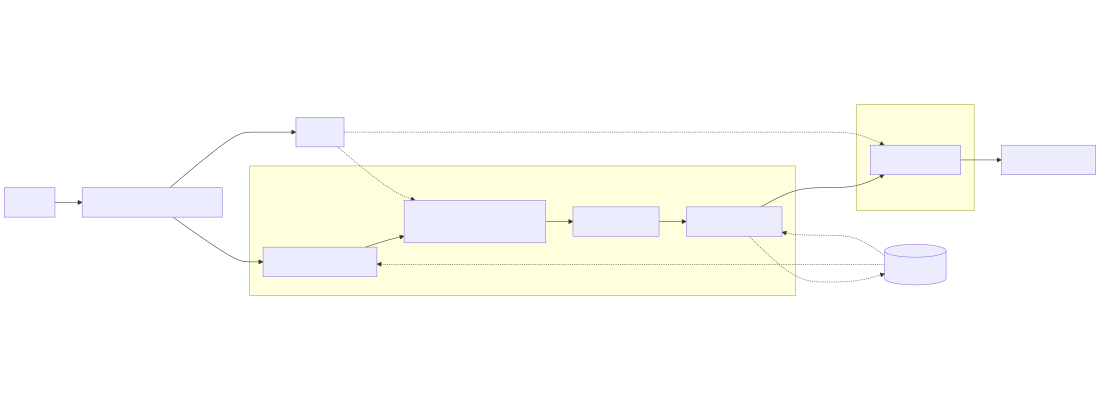

In [13]:
#@markdown   <p><font size="4" color='green'> 🧜 Mermaid-Diagramm</font> </br></p>

# ✅ OPTIMIERUNG: Parametrisierte Funktion statt 4x kopiertes Diagramm
def show_architecture(highlight=None):
    """Zeigt die SQL-RAG Architektur mit optionaler Hervorhebung.

    Args:
        highlight: None, "sql", "output" oder "ui"
    """
    styles = {
        "sql": "\n    style SQL fill:#4a90d9,stroke:#2d5a87,color:#fff",
        "output": "\n    style Output fill:#4a90d9,stroke:#2d5a87,color:#fff",
        "ui": "\n    style Gradio fill:#4a90d9,stroke:#2d5a87,color:#fff\n    style RESULT fill:#4a90d9,stroke:#2d5a87,color:#fff",
    }

    diagram = """
flowchart LR
    USER["User"] --> Gradio["Gradio: chatbot_response()"]

    subgraph SQL["<b>SQL-Abfrage</b>"]
        direction TB
        schema_cache["db_schema (cached)"]
        sql_gen["sql_generator (structured output)"]
        validate["validate_sql()"]
        exec["execute_query()"]
        schema_cache --> sql_gen --> validate --> exec
    end

    subgraph Output["<b>Erstellung Output </b>"]
        direction TB
        analyze["analysis_chain"]
    end

    Gradio --> schema_cache
    Gradio --> LLM["LLM"]
    exec --> analyze
    analyze --> RESULT["Gradio: Antwort"]

    DB[(northwind.db)] -.-> |"Schema (einmalig)"| schema_cache
    exec -.-> |"SQL"| DB
    DB -.-> |"Ergebnis"| exec

    LLM -.-> sql_gen
    LLM -.-> analyze
""" + styles.get(highlight, "")

    mermaid(diagram, width=1100, height=400)

# Gesamtübersicht
show_architecture()

<p><font color='black' size="5">
Programm
</font></p>

In [14]:
# ✅ OPTIMIERUNG: Konsolidierte Imports (kein 're' mehr nötig!)
import gradio as gr
from pydantic import BaseModel, Field
from langchain_community.utilities import SQLDatabase
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [15]:
# Relativer Pfad
DB_PATH = "northwind.db"
DB_URI = f"sqlite:///{DB_PATH}"

In [16]:
# LLM
llm = init_chat_model("openai:gpt-4o-mini", temperature=0.0)

# SQL-Datenbank initialisieren
db = SQLDatabase.from_uri(DB_URI)

# Schema einmalig laden und cachen
db_schema = db.get_table_info()
print(f"Schema geladen: {len(db_schema)} Zeichen")

Schema geladen: 8910 Zeichen


<p><font color='black' size="5">
SQL & Analyse Prompts
</font></p>

Die Prompts sind als **Markdown-Templates** in `05_prompt/` ausgelagert und werden via `load_chat_prompt_template()` von GitHub geladen:

- `sql_rag_generator.md` — SQL-Generierung mit Historie-Kontext
- `sql_rag_analysis.md` — Business-Analyse der Ergebnisse

In [17]:
# ✅ OPTIMIERUNG: Prompt als Markdown-Template ausgelagert (05_prompt/)
#    Prompt braucht keine "KEINE Markdown" Anweisung mehr,
#    da with_structured_output() die Formatierung erzwingt.
sql_prompt = load_chat_prompt_template(
    "https://raw.githubusercontent.com/ralf-42/GenAI/main/05_prompt/sql_rag_generator.md"
)
print(f"SQL-Prompt geladen: {len(sql_prompt.messages)} Messages")

HTTPError: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/ralf-42/GenAI/main/05_prompt/sql_rag_generator.md

In [ ]:
# ✅ OPTIMIERUNG: Prompt als Markdown-Template ausgelagert (05_prompt/)
analysis_prompt = load_chat_prompt_template(
    "https://raw.githubusercontent.com/ralf-42/GenAI/main/05_prompt/sql_rag_analysis.md"
)
print(f"Analyse-Prompt geladen: {len(analysis_prompt.messages)} Messages")

<p><font color='black' size="5">
SQL-Abfrage
</font></p>

In [ ]:
# ✅ OPTIMIERUNG: Wiederverwendung der parametrisierten Funktion
show_architecture(highlight="sql")

In [ ]:
# ✅ OPTIMIERUNG: Pydantic-Model für strukturierte SQL-Ausgabe
class SQLQuery(BaseModel):
    """Strukturierte SQL-Abfrage."""
    sql: str = Field(description="Reine SQL-Abfrage (nur SELECT, ohne Markdown/Formatierung)")

# with_structured_output: LLM gibt direkt ein SQLQuery-Objekt zurück
sql_llm = llm.with_structured_output(SQLQuery)

In [ ]:
# ✅ OPTIMIERUNG: Schema aus Cache + structured output
sql_generator = (
    RunnablePassthrough.assign(schema=lambda _: db_schema)
    | sql_prompt
    | sql_llm
)

# ✅ OPTIMIERUNG: Analysis-Chain einmalig definieren (statt bei jedem Aufruf neu)
analysis_chain = analysis_prompt | llm | StrOutputParser()

In [ ]:
# ✅ OPTIMIERUNG: SQL-Validierung direkt in execute_query integriert
#    (statt in separatem, ungenutztem Abschnitt 6)
def validate_sql(sql_query: str) -> tuple[bool, str]:
    """Validiert eine SQL-Abfrage auf Sicherheit."""
    if not sql_query.strip().upper().startswith("SELECT"):
        return False, "Nur SELECT-Anweisungen sind erlaubt."

    dangerous_commands = ["DROP", "DELETE", "TRUNCATE", "UPDATE", "INSERT", "ALTER"]
    for command in dangerous_commands:
        if f" {command} " in sql_query.upper():
            return False, f"Unerlaubter SQL-Befehl: {command}"

    return True, "OK"


def execute_query(sql_query: str) -> str:
    """Validiert und führt eine SQL-Abfrage aus."""
    # Sicherheitsprüfung vor Ausführung
    is_valid, message = validate_sql(sql_query)
    if not is_valid:
        return f"⚠️ Sicherheitsfehler: {message}"

    try:
        result = db.run(sql_query)
        if not result or result.strip() == "":
            return "Keine Ergebnisse gefunden."
        return result
    except Exception as e:
        return f"Fehler bei der Ausführung: {str(e)}"

<p><font color='black' size="5">
Erstellung Output
</font></p>

In [ ]:
# ✅ OPTIMIERUNG: Wiederverwendung der parametrisierten Funktion
show_architecture(highlight="output")

In [ ]:
# ✅ OPTIMIERUNG: Historie-Formatierung als eigene Funktion
def format_history(history) -> str:
    """Formatiert Gradio-Historie für LLM-Kontext (letzte 3 Einträge)."""
    if not history:
        return ""

    parts = []
    for i, (user_msg, bot_msg) in enumerate(history[-3:], 1):
        parts.append(f"[Vorherige Frage {i}]: {user_msg}")
        if bot_msg and "### Analyse" in bot_msg:
            analysis_part = bot_msg.split("### Analyse")[-1].strip()
            parts.append(f"[Vorherige Antwort {i}]: {analysis_part[:300]}")
    return "\n".join(parts)


# ✅ OPTIMIERUNG: Nutzt vordefinierte analysis_chain (statt pro Aufruf neu)
def analyze_results(query, sql_query, results, history_text=""):
    """Analysiert die Ergebnisse und gibt eine natürlichsprachliche Antwort zurück."""
    return analysis_chain.invoke({
        "query": query,
        "sql_query": sql_query,
        "results": results,
        "history_text": history_text
    })

<p><font color='black' size="5">
UI Gradio In/Out
</font></p>

In [ ]:
# ✅ OPTIMIERUNG: Wiederverwendung der parametrisierten Funktion
show_architecture(highlight="ui")

In [ ]:
# ✅ OPTIMIERUNG: Schlanker dank ausgelagerter Funktionen und structured output
def chatbot_response(message, history):
    """Verarbeitet Benutzeranfragen mit optimierter SQL-RAG Pipeline."""
    try:
        # Historie formatieren (ausgelagerte Funktion)
        history_text = format_history(history)

        # SQL generieren (structured output - kein Regex nötig!)
        result = sql_generator.invoke({
            "query": message,
            "history_text": history_text
        })
        sql_query = result.sql  # Pydantic-Objekt → sauberer String

        # Debug-Ausgabe
        print(f"Generierte SQL: {sql_query}")

        # Abfrage Datenbank (mit integrierter Validierung)
        results = execute_query(sql_query)

        # Analysiere die Ergebnisse (vordefinierte Chain)
        analysis = analyze_results(message, sql_query, results, history_text)

        # Antwort formatieren
        return f"""### Deine Anfrage
{message}

### SQL-Abfrage
```sql
{sql_query}
```

### Ergebnisse
{results}

### Analyse
{analysis}"""

    except Exception as e:
        import traceback
        error_details = traceback.format_exc()
        print(f"Fehler Details:\n{error_details}")
        return f"Ein Fehler ist aufgetreten: {str(e)}\n\nDetails siehe Console-Output."

In [ ]:
# Beispielfragen für Gradio-Interface definieren
example_questions = [
    "Welche Produkte sind aktuell nicht mehr auf Lager? Nenne die Top 3.",
    "Welche Bestellung von welchem Kunden hatte den höchsten Gesamtwert? Nenne die Top 3.",
    "Aus welchen Ländern stammen die meisten Kunden? Nenne die Top 3.",
    "Sind alle Artikel der Bestellung der Rattlesnake Canyon Grocery vom 1998-05-06 in ausreichender Anzahl auf Lager?",
]

In [ ]:
# Gradio Interface erstellen
demo = gr.ChatInterface(
    fn=chatbot_response,
    title="📚 SQL RAG - Optimierte Version (LangChain 1.0+)",
    description="""**Features:**
- 💬 **Chat-Historie**: Stelle Folge-Fragen basierend auf vorherigen Antworten
- 🤖 **Structured Output**: SQL-Generierung über `with_structured_output()` (kein Regex)
- 🔒 **Integrierte Validierung**: SQL-Sicherheitsprüfung vor jeder Ausführung
- ⚡ **Schema-Caching**: DB-Schema einmalig geladen (Performance)
- 📊 **Intelligente Analyse**: Automatische Interpretation der Ergebnisse

""",
    examples=example_questions,
)

<p><font color='black' size="5">
Starten der App
</font></p>

**Beispiel-Fragen:**



+ Gib die Artikelliste für die Bestellung 11031 mit Einzelpreis und Gesamtpreis aus, wobei sich der Gesamtpreis aus der Anzahl und dem Einzelpreis ergibt.
+ Welcher Mitarbeiter ist für die Bestellung mit der Nummer 10266 zuständig?
+ Über welche Versandfirma wurde die Bestellung 10266 ausgeliefert?
+ Sind alle Artikel der Bestellung der Rattlesnake Canyon Grocery vom 1998-05-06 in ausreichender Anzahl auf Lager?
+ Welche Kunden haben schon Artikel der Firma 'Escargots Nouveaux' gekauft?




In [ ]:
# App starten
demo.launch()


# 6 | Validierung und Sicherheit
---



Die Sicherheit ist bei der Arbeit mit datenbankgesteuerten Anwendungen von entscheidender Bedeutung. SQL RAG-Implementierungen müssen folgende Sicherheitsaspekte berücksichtigen:

1. **SQL-Injection-Prävention**:
    
    - Validierung und Bereinigung generierter SQL-Abfragen
    - Verwendung von parametrisierten Abfragen
    - Beschränkung der SQL-Befehle (z.B. nur SELECT-Anweisungen zulassen)
2. **Zugriffskontrolle**:
    
    - Verwendung von Datenbanknutzern mit eingeschränkten Rechten
    - Zugriffsbeschränkungen auf bestimmte Tabellen oder Ansichten
    - Implementierung von Row-Level-Security
3. **Datenvalidierung**:
    
    - Überprüfung der generierten SQL-Abfragen auf verdächtige Muster
    - Begrenzung der Abfragekomplexität und -länge
    - Timeouts für lang laufende Abfragen


In [ ]:
# ✅ OPTIMIERUNG: In dieser Version ist die Validierung bereits in execute_query()
#    integriert (siehe Abschnitt 5). Hier nochmal die Standalone-Version zur Demonstration:

def validate_sql_query(sql_query):
    """Validiert eine SQL-Abfrage auf potenziell gefährliche Muster."""

    # Nur SELECT-Anweisungen erlauben
    if not sql_query.strip().upper().startswith("SELECT"):
        return False, "Nur SELECT-Anweisungen sind erlaubt."

    # Keine gefährlichen SQL-Befehle erlauben
    dangerous_commands = ["DROP", "DELETE", "TRUNCATE", "UPDATE", "INSERT", "ALTER"]
    for command in dangerous_commands:
        if f" {command} " in sql_query.upper():
            return False, f"Unerlaubter SQL-Befehl: {command}"

    return True, "SQL-Abfrage ist gültig."

# Test mit verschiedenen Abfragen
print("SELECT-Test:", validate_sql_query("SELECT * FROM Products"))
print("DROP-Test:  ", validate_sql_query("DROP TABLE Products"))
print("DELETE-Test:", validate_sql_query("DELETE FROM Products WHERE id=1"))

Eine gründliche Validierung vor der Ausführung ist entscheidend für die Sicherheit der Anwendung.


# 7 | Praktische Anwendungsfälle
---

SQL RAG eignet sich für zahlreiche praktische Anwendungsfälle:

1. **Business Intelligence Dashboards**:
    
    - Natürlichsprachliche Abfragen für Geschäftskennzahlen
    - Dynamische Berichte basierend auf Benutzeranfragen
    - Trends und Anomalien in Daten identifizieren
2. **Datenanalyse für Nicht-Techniker**:
    
    - Ermöglicht Benutzern ohne SQL-Kenntnisse, komplexe Datenabfragen durchzuführen
    - Vereinfacht den Zugang zu Unternehmensdaten
3. **Automatisierte Berichterstellung**:
    
    - Generierung regelmäßiger Berichte basierend auf Datenabfragen
    - Intelligente Zusammenfassung und Interpretation von Geschäftsdaten
4. **Kundenservice-Anwendungen**:
    
    - Schneller Zugriff auf Kundendaten für Support-Mitarbeiter
    - Automatisierte Beantwortung häufiger Kundenanfragen
5. **Interne Wissensmanagement-Systeme**:
    
    - Intelligente Suche in Unternehmensdaten
    - Verknüpfung verschiedener Datenquellen für umfassende Antworten

Durch die Kombination von LLMs mit Datenbankabfragen kann SQL RAG komplexe Analyseaufgaben automatisieren und den Zugang zu Daten demokratisieren.



# A | Aufgabe
---

Die Aufgabestellungen unten bieten Anregungen, Sie können aber auch gerne eine andere Herausforderung angehen.

Angenommen, es wird für ein kleines Unternehmen gearbeitet, das eine Kundendatenbank verwaltet. Ziel ist es, eine generative KI einzusetzen, um Anfragen in natürlicher Sprache zu verstehen und relevante Informationen aus der Datenbank abzurufen.  

**Datenbankstruktur (SQLite-Format)**  
Die Kundendatenbank enthält eine Tabelle `customers.db` mit den folgenden Spalten:  

| id | name  | city    | purchases |
|----|-------|--------|-----------|
| 1  | Alice  | Berlin  | 5         |
| 2  | Bob    | Hamburg | 2         |
| 3  | Carol  | München | 7         |
| 4  | David  | Köln    | 3         |



**Aufgabenstellung**  
1. **Abfrage erstellen**, um die Anzahl der Einkäufe (`purchases`) eines bestimmten Kunden anhand seines Namens abzurufen.  
2. **Python-Funktion entwickeln**, die eine GPT-API nutzt, um natürliche Sprachabfragen in SQL-Abfragen zu übersetzen.  
3. **Funktion testen**, indem eine Frage wie *„Wie viele Einkäufe hat Alice gemacht?“* gestellt wird, woraufhin das System automatisch die entsprechende SQL-Abfrage generiert.  

